In [7]:
import xarray as xr
import pandas as pd
import dask.array as da
from dask import delayed
import os
import matplotlib.pyplot as plt

In [8]:
# Files name list
directory = 'F:/GOES_Files/GOES_Files_B05'
Band = 5

if Band<10:
    band_str = 'M6C0' + str(Band)
else:
    band_str = 'M6C' + str(Band)
ncs = [f'{directory}/{i}' 
       for i in os.listdir(directory) 
       if i.endswith('.nc') 
       and band_str in i
       # Select only files each hour (starting at hh:00)
       and i.split('_')[3][10:12] == '00']
ncs

['F:/GOES_Files/GOES_Files_B05/OR_ABI-L2-CMIPF-M6C05_G16_s20231210000203_e20231210009511_c20231210009583.nc',
 'F:/GOES_Files/GOES_Files_B05/OR_ABI-L2-CMIPF-M6C05_G16_s20231210100203_e20231210109511_c20231210110017.nc',
 'F:/GOES_Files/GOES_Files_B05/OR_ABI-L2-CMIPF-M6C05_G16_s20231210200203_e20231210209511_c20231210210010.nc',
 'F:/GOES_Files/GOES_Files_B05/OR_ABI-L2-CMIPF-M6C05_G16_s20231210300203_e20231210309511_c20231210309591.nc',
 'F:/GOES_Files/GOES_Files_B05/OR_ABI-L2-CMIPF-M6C05_G16_s20231210400203_e20231210409511_c20231210409589.nc',
 'F:/GOES_Files/GOES_Files_B05/OR_ABI-L2-CMIPF-M6C05_G16_s20231210500205_e20231210509513_c20231210510017.nc',
 'F:/GOES_Files/GOES_Files_B05/OR_ABI-L2-CMIPF-M6C05_G16_s20231210600205_e20231210609513_c20231210610013.nc',
 'F:/GOES_Files/GOES_Files_B05/OR_ABI-L2-CMIPF-M6C05_G16_s20231210700205_e20231210709513_c20231210710019.nc',
 'F:/GOES_Files/GOES_Files_B05/OR_ABI-L2-CMIPF-M6C05_G16_s20231210800205_e20231210809513_c20231210809593.nc',
 'F:/GOES_

In [9]:
# Trim and reescale images 
das = []
target_x_res = 200
target_y_res = 200
for nc in ncs:
    ds = delayed(xr.open_dataset)(nc) 
    ds_sel = delayed(ds.sel)(x=slice(-0.05, 0.07), y=slice(0.09, -0.03))
    original_x_size = delayed(ds_sel.dims['x'])
    original_y_size = delayed(ds_sel.dims['y'])
    scale_factor_x = delayed(lambda ox: max(ox // target_x_res, 1))(original_x_size)
    scale_factor_y = delayed(lambda oy: max(oy // target_y_res, 1))(original_y_size)
    
    # Apply the downscaling factor to each image
    ds_downscaled = delayed(ds_sel.coarsen)(x=scale_factor_x, y=scale_factor_y, boundary="trim").mean()
    
    das.append(ds_downscaled)

# concatenation 
ds_col = delayed(xr.concat)(das, dim='t')

# Convert to a Dask array for processing
ds_col = ds_col.compute()
ds_col

d:\RODRIGO\Python projects\GOES Xarray\goesCorr\Lib\site-packages\dask\core.py:127: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return func(*(_execute_task(a, cache) for a in args))
d:\RODRIGO\Python projects\GOES Xarray\goesCorr\Lib\site-packages\dask\core.py:127: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return func(*(_execute_task(a, cache) for a in args))
d:\RODRIGO\Python projects\GOES Xarray\goesCorr\Lib\site-packages\dask\core.py:127: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent wi

<xarray.Dataset> Size: 231MB
Dimensions:                                           (t: 693, y: 204, x: 204,
                                                       number_of_time_bounds: 2,
                                                       number_of_image_bounds: 2,
                                                       band: 1)
Coordinates:
  * t                                                 (t) datetime64[ns] 6kB ...
  * y                                                 (y) float32 816B 0.0897...
  * x                                                 (x) float32 816B -0.049...
    y_image                                           float32 4B 0.0
    x_image                                           float32 4B 0.0
    band_wavelength                                   (band) float32 4B 1.61
    band_id                                           (band) int32 4B 5
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/35)
    CMI                                               (t, y, x) float32 115MB ...
    DQF                                               (t, y, x) float32 115MB ...
    time_bounds                                       (t, number_of_time_bounds) datetime64[ns] 11kB ...
    goes_imager_projection                            (t) int32 3kB -21474836...
    y_image_bounds                                    (t, number_of_image_bounds) float32 6kB ...
    x_image_bounds                                    (t, number_of_image_bounds) float32 6kB ...
    ...                                                ...
    focal_plane_temperature_threshold_exceeded_count  (t) float64 6kB nan ......
    maximum_focal_plane_temperature                   (t) float32 3kB nan ......
    focal_plane_temperature_threshold_increasing      (t) float32 3kB nan ......
    focal_plane_temperature_threshold_decreasing      (t) float32 3kB nan ......
    channel_integration_time                          (t) float64 6kB 0.0 ......
    channel_gain_field                                (t) float64 6kB 0.0 ......
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-05-01T00:00:20.3Z
    time_coverage_end:         2023-05-01T00:09:51.1Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        5c3f23c7-9fce-40dd-aefd-ba91de1fa2a6

In [10]:
# Save the dataset to a NetCDF file
output_path = 'F:/GOES_Files/combined_data.nc'
ds_col.to_netcdf(output_path)

C:\Users\rodhe\AppData\Local\Temp\ipykernel_18936\579394311.py:3: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_col.to_netcdf(output_path)
C:\Users\rodhe\AppData\Local\Temp\ipykernel_18936\579394311.py:3: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_col.to_netcdf(output_path)


In [11]:
# Load a dataset from a NetCDF file
file_path = 'F:/GOES_Files/combined_data.nc'
ds_col = xr.open_dataset(file_path)

In [13]:
ds_col['t'] = [pd.Timestamp(i, tz='UTC').floor('10min') for i in ds_col.t.values]

In [12]:
# load the excel data for GHI
df = pd.read_excel('F:/GOES_Files/limpios.xlsx')
df['t'] = pd.to_datetime(df['Time'], utc='UTC')
df.set_index('t', inplace=True)

ghi_da = xr.DataArray(data=df.ghi, dims=['t'], coords={'t': df.index})

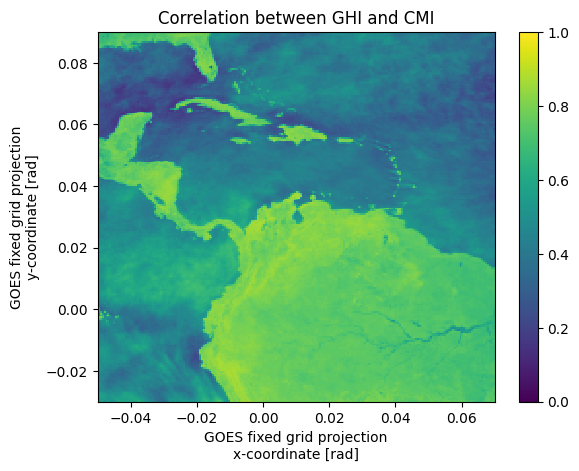

In [24]:
# Calculate and plot the correlation of GHI and CMI data
corr = xr.corr(ds_col.CMI, ghi_da, dim='t')

corr.plot(vmin=0, vmax = 1)
plt.title('Correlation between GHI and CMI')
plt.show()

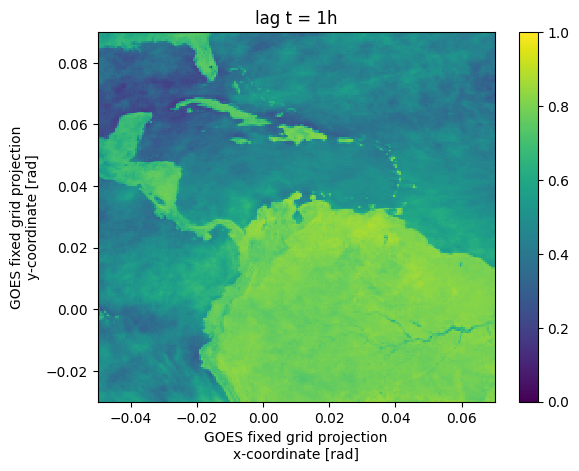

In [25]:
corr_lag = xr.corr(ds_col.CMI.shift(t=1), xr.DataArray(data=df.ghi), dim=('t'))
corr_lag.plot(vmin=0, vmax = 1)
plt.title('lag t = 1h')
plt.show()

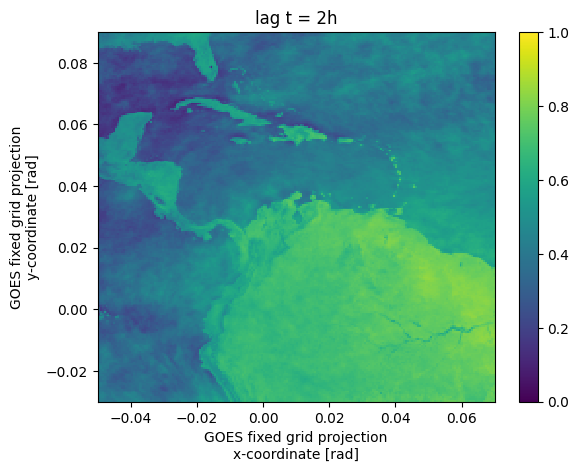

In [26]:
corr_lag = xr.corr(ds_col.CMI.shift(t=2), xr.DataArray(data=df.ghi), dim=('t'))
corr_lag.plot(vmin=0, vmax = 1)
plt.title('lag t = 2h')
plt.show()

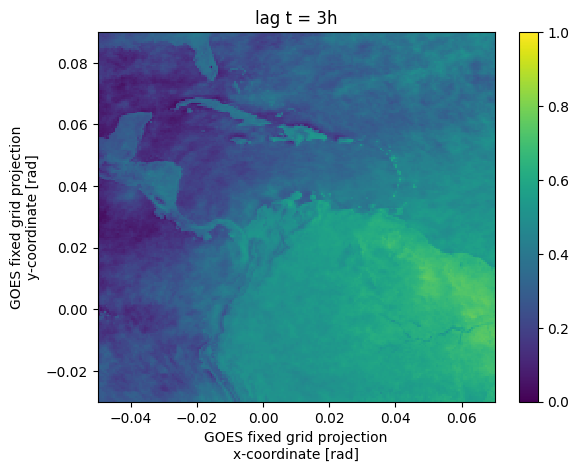

In [27]:
corr_lag = xr.corr(ds_col.CMI.shift(t=3), xr.DataArray(data=df.ghi), dim=('t'))
corr_lag.plot(vmin=0, vmax = 1)
plt.title('lag t = 3h')
plt.show()

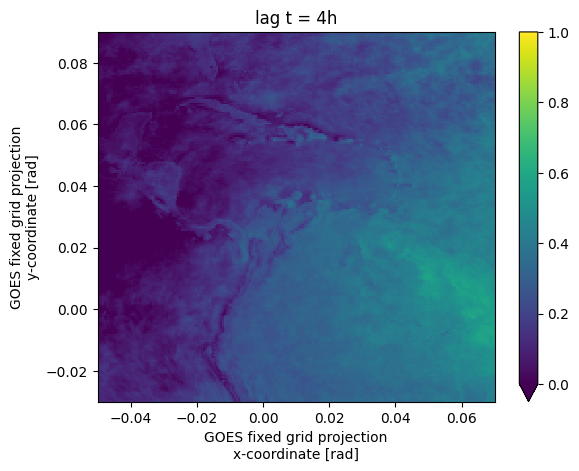

In [28]:
corr_lag = xr.corr(ds_col.CMI.shift(t=4), xr.DataArray(data=df.ghi), dim=('t'))
corr_lag.plot(vmin=0, vmax = 1)
plt.title('lag t = 4h')
plt.show()

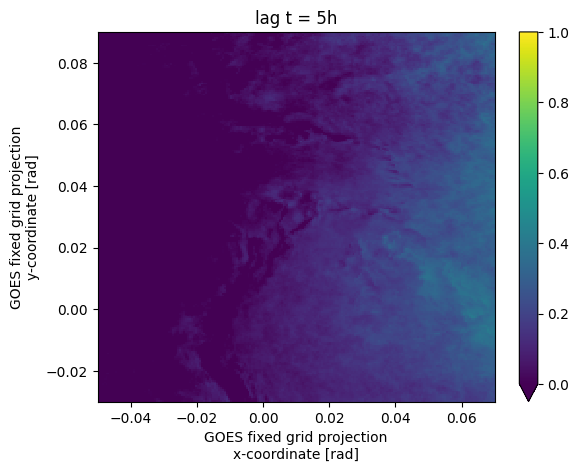

In [29]:
corr_lag = xr.corr(ds_col.CMI.shift(t=5), xr.DataArray(data=df.ghi), dim=('t'))
corr_lag.plot(vmin=0, vmax = 1)
plt.title('lag t = 5h')
plt.show()

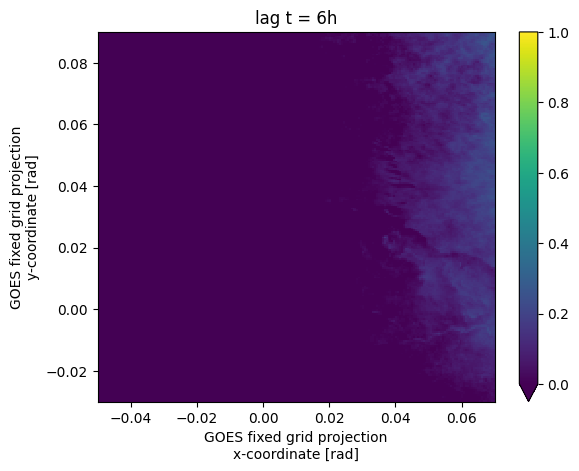

In [30]:
corr_lag = xr.corr(ds_col.CMI.shift(t=6), xr.DataArray(data=df.ghi), dim=('t'))
corr_lag.plot(vmin=0, vmax = 1)
plt.title('lag t = 6h')
plt.show()

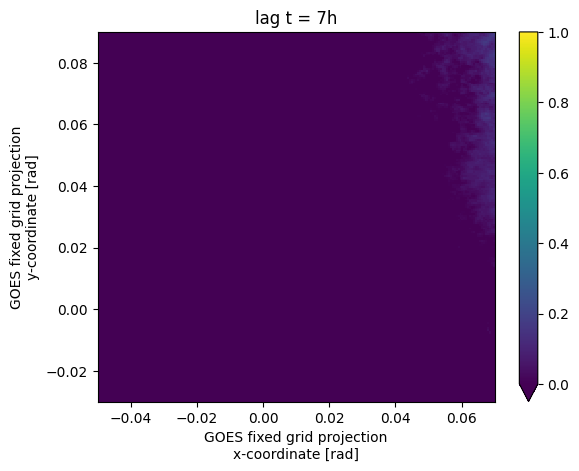

In [31]:
corr_lag = xr.corr(ds_col.CMI.shift(t=7), xr.DataArray(data=df.ghi), dim=('t'))
corr_lag.plot(vmin=0, vmax = 1)
plt.title('lag t = 7h')
plt.show()

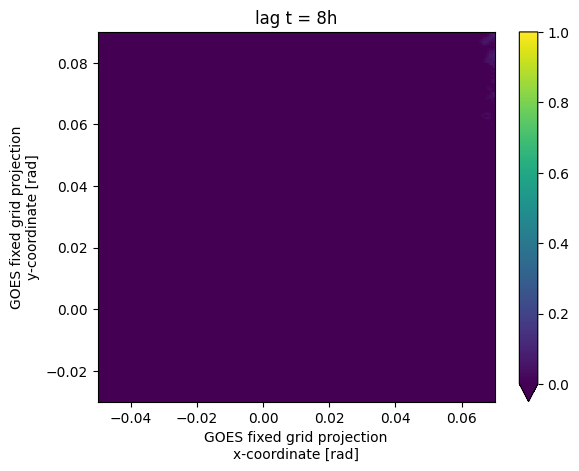

In [32]:
corr_lag = xr.corr(ds_col.CMI.shift(t=8), xr.DataArray(data=df.ghi), dim=('t'))
corr_lag.plot(vmin=0, vmax = 1)
plt.title('lag t = 8h')
plt.show()